<a href="https://colab.research.google.com/github/rizkirmdhnnn/UAS-Data-Mining/blob/main/Klasifikasi_Pneumonia_KNN_%2B_GLCM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pendekatan Machine Learning dengan KNN untuk Klasifikasi Pneumonia pada Citra X-ray dengan Fitur GLCM**

> Add blockquote



Import Library

In [ ]:
import kagglehub
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure

Download Dataset


In [ ]:
# Download Dataset
path = kagglehub.dataset_download("assemelqirsh/chest-x-ray-dataset")

# Pindah ke /content/dataset
!mv {path} /content/dataset

mv: inter-device move failed: '/kaggle/input/chest-x-ray-dataset' to '/content/dataset/chest-x-ray-dataset'; unable to remove target: Directory not empty


## EDA


Membuat Dataframe

In [ ]:
from pathlib import Path
import pandas as pd
import os
from PIL import Image

# Direktori dataset
val_dir = '/content/dataset/chest_xray/val'
train_dir = '/content/dataset/chest_xray/train'
test_dir = '/content/dataset/chest_xray/test'

# Fungsi untuk membuat DataFrame dengan kolom tambahan
def buat_df_dari_path(direktori):
    # List kosong untuk menyimpan data
    kelas = []
    nama_gambar = []
    path_gambar = []
    ukuran_file_kb = []
    resolusi = []

    # Menelusuri direktori
    for path in Path(direktori).rglob('*.*'):
        if path.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff']:
            try:
                # Mendapatkan nama kelas dan nama file gambar
                nama_kelas = path.parts[-2]
                nama_file = path.parts[-1]

                # Path lengkap
                path_lengkap = str(path)

                # Ukuran file dalam KB
                ukuran_kb = os.path.getsize(path_lengkap) / 1024

                # Resolusi gambar
                with Image.open(path_lengkap) as img:
                    lebar, tinggi = img.size
                    resolusi_gambar = f"{lebar}x{tinggi}"

                # Tambahkan ke dalam list
                kelas.append(nama_kelas)
                nama_gambar.append(nama_file)
                path_gambar.append(path_lengkap)
                ukuran_file_kb.append(round(ukuran_kb, 2))
                resolusi.append(resolusi_gambar)

            except Exception as e:
                print(f"Gagal memproses {path}: {e}")
                continue

    # Membuat DataFrame
    df = pd.DataFrame({
        'Kelas': kelas,
        'Nama_Gambar': nama_gambar,
        'Path': path_gambar,
        'Ukuran_KB': ukuran_file_kb,
        'Resolusi': resolusi
    })

    # Urutkan berdasarkan kelas dan reset indeks
    df = df.sort_values('Kelas', ascending=True)
    df.reset_index(drop=True, inplace=True)

    return df

# Membuat DataFrame untuk masing-masing set data
df_train = buat_df_dari_path(train_dir)
df_test = buat_df_dari_path(test_dir)
df_val = buat_df_dari_path(val_dir)

# Tampilkan hasil
print("Data Latih (Training):")
print(df_train.head())
print(f"Total gambar pelatihan: {len(df_train)}")

print("\nData Uji (Testing):")
print(df_test.head())
print(f"Total gambar pengujian: {len(df_test)}")

print("\nData Validasi:")
print(df_val.head())
print(f"Total gambar validasi: {len(df_val)}")


Training data:
    Class                     Images  \
0  NORMAL          IM-0236-0001.jpeg   
1  NORMAL          IM-0633-0001.jpeg   
2  NORMAL          IM-0750-0001.jpeg   
3  NORMAL          IM-0485-0001.jpeg   
4  NORMAL  NORMAL2-IM-1320-0001.jpeg   

                                                Path  Size_KB Resolution  
0  /content/dataset/chest_xray/train/NORMAL/IM-02...    23.44    244x244  
1  /content/dataset/chest_xray/train/NORMAL/IM-06...    21.00    244x244  
2  /content/dataset/chest_xray/train/NORMAL/IM-07...    21.81    244x244  
3  /content/dataset/chest_xray/train/NORMAL/IM-04...    24.61    244x244  
4  /content/dataset/chest_xray/train/NORMAL/NORMA...    21.99    244x244  
Total gambar train: 2121

Test data:
    Class                     Images  \
0  NORMAL  NORMAL2-IM-0853-0001.jpeg   
1  NORMAL          IM-0504-0001.jpeg   
2  NORMAL          IM-0227-0001.jpeg   
3  NORMAL  NORMAL2-IM-1328-0001.jpeg   
4  NORMAL          IM-0234-0001.jpeg   

                

Informasi Dataframe

In [ ]:
# Statistik Dataset
total_images = len(df_train) + len(df_test) + len(df_val)
print("Jumlah Gambar (total): {}".format(total_images))
print("Jumlah Class (total): {}".format(len(pd.concat([df_train, df_test, df_val])['Class'].unique())))

# Statistik Dataset Training
print('Statistik Training Dataset:')
train_class_counts = df_train['Class'].value_counts()
print("Jumlah Gambar: {}".format(len(df_train)))
print("Jumlah gambar pada masing masing class:")
print(train_class_counts)
print()

# Statistik Dataset Testing
print('Statistik Testing Dataset:')
test_class_counts = df_test['Class'].value_counts()
print("Jumlah Gambar: {}".format(len(df_test)))
print("Jumlah gambar pada masing masing class:")
print(test_class_counts)
print()

# Statistik Dataset Validation
print('Statistik Validation Dataset:')
val_class_counts = df_val['Class'].value_counts()
print("Jumlah Gambar: {}".format(len(df_val)))
print("Jumlah gambar pada masing masing class:")
print(val_class_counts)
print()

Jumlah Gambar (total): 3293
Jumlah Class (total): 2
Statistik Training Dataset:
Jumlah Gambar: 2121
Jumlah gambar pada masing masing class:
Class
NORMAL       1266
PNEUMONIA     855
Name: count, dtype: int64

Statistik Testing Dataset:
Jumlah Gambar: 587
Jumlah gambar pada masing masing class:
Class
PNEUMONIA    428
NORMAL       159
Name: count, dtype: int64

Statistik Validation Dataset:
Jumlah Gambar: 585
Jumlah gambar pada masing masing class:
Class
PNEUMONIA    427
NORMAL       158
Name: count, dtype: int64



Distribusi Label

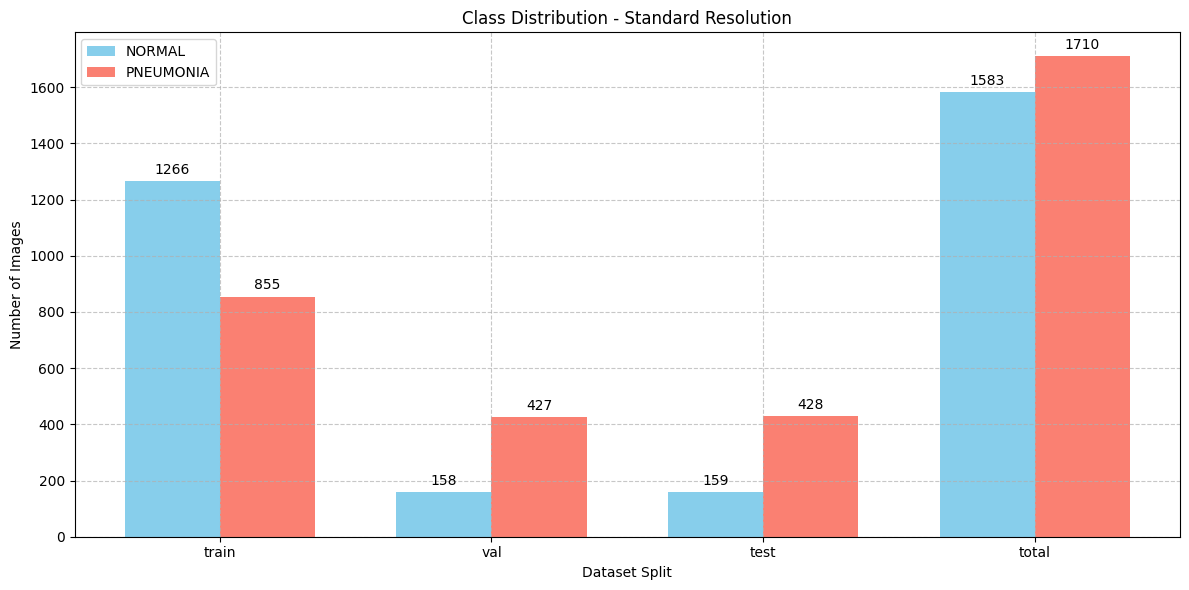

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_distribution(df_train, df_val, df_test, title):
    """Plot class distribution for all splits without using 'stats'."""

    # Menghitung jumlah untuk setiap kelas (NORMAL, PNEUMONIA) di setiap dataset
    normal_counts_train = df_train['Class'].value_counts().get('NORMAL', 0)
    pneumonia_counts_train = df_train['Class'].value_counts().get('PNEUMONIA', 0)

    normal_counts_val = df_val['Class'].value_counts().get('NORMAL', 0)
    pneumonia_counts_val = df_val['Class'].value_counts().get('PNEUMONIA', 0)

    normal_counts_test = df_test['Class'].value_counts().get('NORMAL', 0)
    pneumonia_counts_test = df_test['Class'].value_counts().get('PNEUMONIA', 0)

    normal_counts_total = len(df_train[df_train['Class'] == 'NORMAL']) + len(df_test[df_test['Class'] == 'NORMAL']) + len(df_val[df_val['Class'] == 'NORMAL'])
    pneumonia_counts_total = len(df_train[df_train['Class'] == 'PNEUMONIA']) + len(df_test[df_test['Class'] == 'PNEUMONIA']) + len(df_val[df_val['Class'] == 'PNEUMONIA'])

    # Menentukan posisi bar
    splits = ['train', 'val', 'test', 'total']
    normal_counts = [normal_counts_train, normal_counts_val, normal_counts_test, normal_counts_total]
    pneumonia_counts = [pneumonia_counts_train, pneumonia_counts_val, pneumonia_counts_test, pneumonia_counts_total]

    x = np.arange(len(splits))
    width = 0.35

    # Membuat figure dan axes
    fig, ax = plt.subplots(figsize=(12, 6))

    # Membuat bar chart
    rects1 = ax.bar(x - width/2, normal_counts, width, label='NORMAL', color='skyblue')
    rects2 = ax.bar(x + width/2, pneumonia_counts, width, label='PNEUMONIA', color='salmon')

    # Menambahkan label dan judul
    ax.set_xlabel('Dataset Split')
    ax.set_ylabel('Number of Images')
    ax.set_title(f'Class Distribution - {title}')
    ax.set_xticks(x)
    ax.set_xticklabels(splits)
    ax.legend()

    # Menambahkan label jumlah di atas setiap bar
    def autolabel(rects):
        """Fungsi untuk menambahkan label pada setiap bar."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Menerapkan fungsi autolabel
    autolabel(rects1)
    autolabel(rects2)

    # Menambahkan garis grid pada sumbu y
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    # Menyesuaikan tata letak untuk tampilan yang lebih rapi
    fig.tight_layout()
    plt.show()

# Panggil fungsi plot dengan dataset df_train, df_val, df_test
plot_distribution(df_train, df_val, df_test, 'Standard Resolution')

Drop beberapa class pneumonia karna imbalance


In [ ]:
import random
import os

# Ambil semua indeks sample Pneumonia
pneumonia_indices = df_train[df_train['Class'] == 'PNEUMONIA'].index.tolist()

# Hitung 40% dari total sample Pneumonia
num_to_drop = int(len(pneumonia_indices) * 0.50)

if num_to_drop > 0:
    # Pilih secara acak indeks yang akan dihapus
    indices_to_drop = random.sample(pneumonia_indices, num_to_drop)

    # Hapus file gambarnya
    for index in indices_to_drop:
        image_path = df_train.loc[index, 'Path']
        if os.path.exists(image_path):
            os.remove(image_path)
            print(f"Deleted image: {image_path}")

    # Langsung update df_train
    df_train.drop(indices_to_drop, inplace=True)
    df_train.reset_index(drop=True, inplace=True)

    print(f"Dropped {num_to_drop} Pneumonia samples and deleted corresponding image files.")
else:
    print("Warning: Not enough Pneumonia samples to drop 20%. No changes made.")

# Sekarang df_train sudah otomatis berkurang isinya
print(df_train['Class'].value_counts())


Deleted image: /content/dataset/chest_xray/train/PNEUMONIA/person1799_bacteria_4647.jpeg
Deleted image: /content/dataset/chest_xray/train/PNEUMONIA/person1156_bacteria_3101.jpeg
Deleted image: /content/dataset/chest_xray/train/PNEUMONIA/person154_virus_306.jpeg
Deleted image: /content/dataset/chest_xray/train/PNEUMONIA/person555_bacteria_2325.jpeg
Deleted image: /content/dataset/chest_xray/train/PNEUMONIA/person1214_virus_2059.jpeg
Deleted image: /content/dataset/chest_xray/train/PNEUMONIA/person1634_bacteria_4326.jpeg
Deleted image: /content/dataset/chest_xray/train/PNEUMONIA/person23_bacteria_100.jpeg
Deleted image: /content/dataset/chest_xray/train/PNEUMONIA/person295_bacteria_1390.jpeg
Deleted image: /content/dataset/chest_xray/train/PNEUMONIA/person1242_virus_2109.jpeg
Deleted image: /content/dataset/chest_xray/train/PNEUMONIA/person1313_virus_2264.jpeg
Deleted image: /content/dataset/chest_xray/train/PNEUMONIA/person714_bacteria_2615.jpeg
Deleted image: /content/dataset/chest_xra

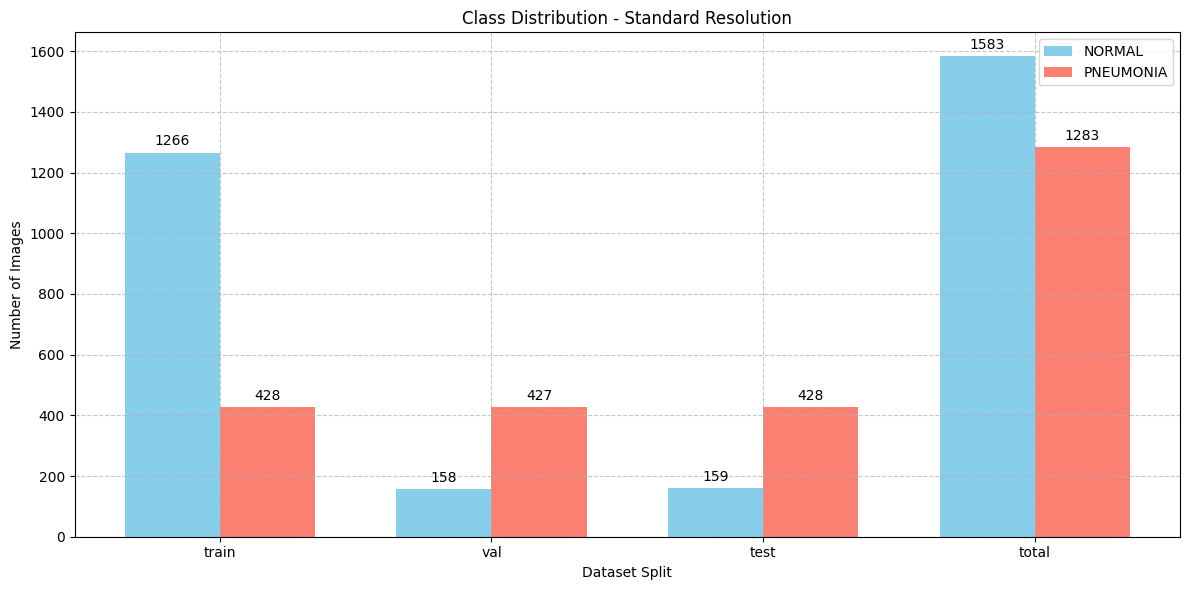

In [ ]:
# Panggil fungsi plot dengan dataset df_train, df_val, df_test
plot_distribution(df_train, df_val, df_test, 'Standard Resolution')

Menampilkan 3 gambar dari masing-masing dataset

Validation Set Images:


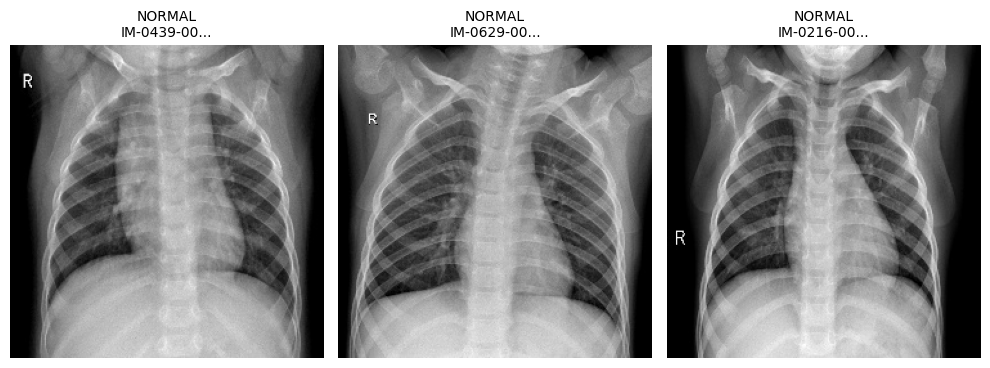

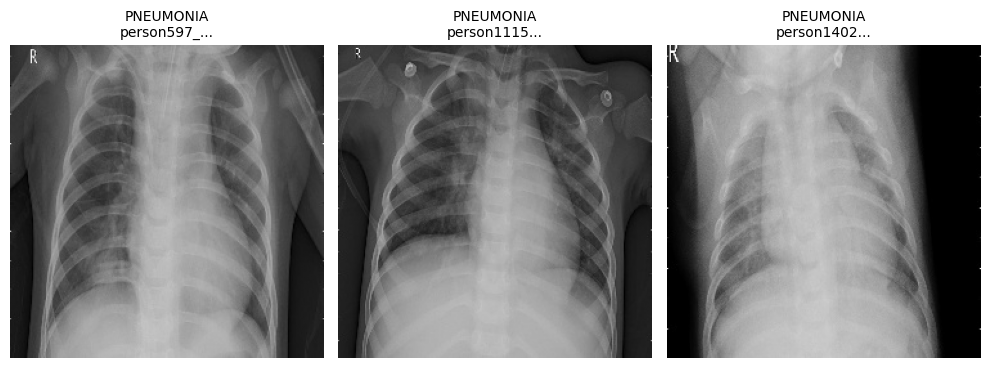


Training Set Images:


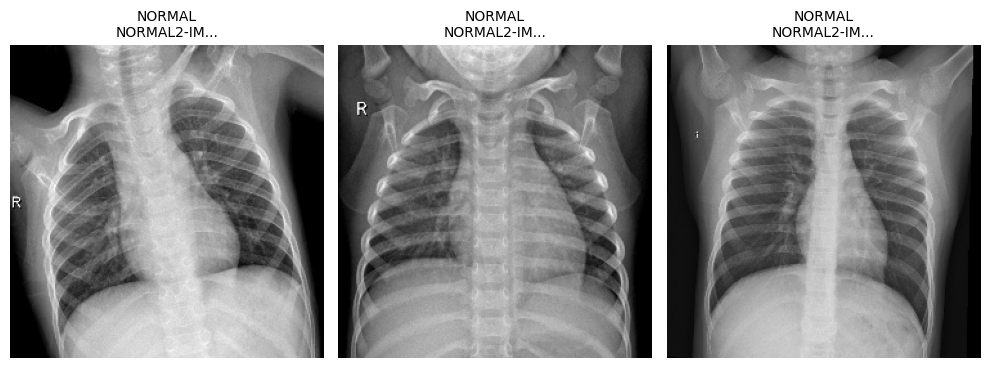

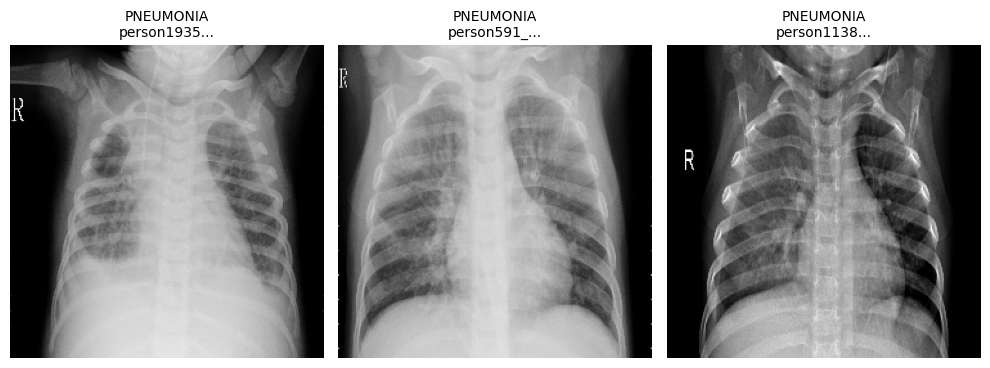


Testing Set Images:


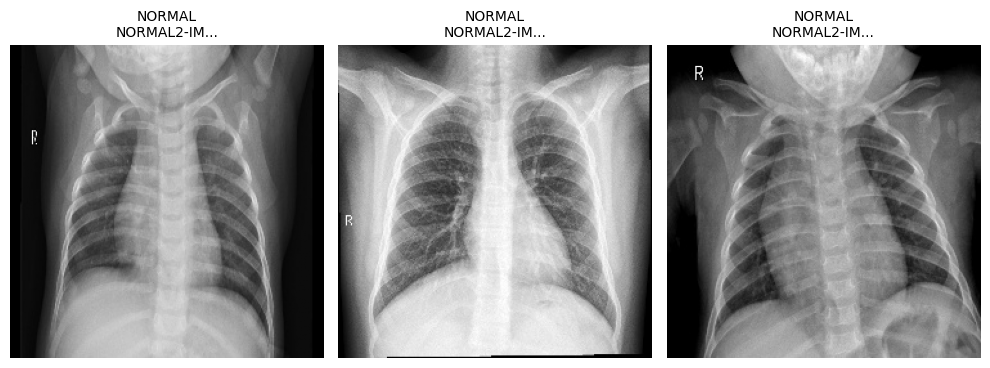

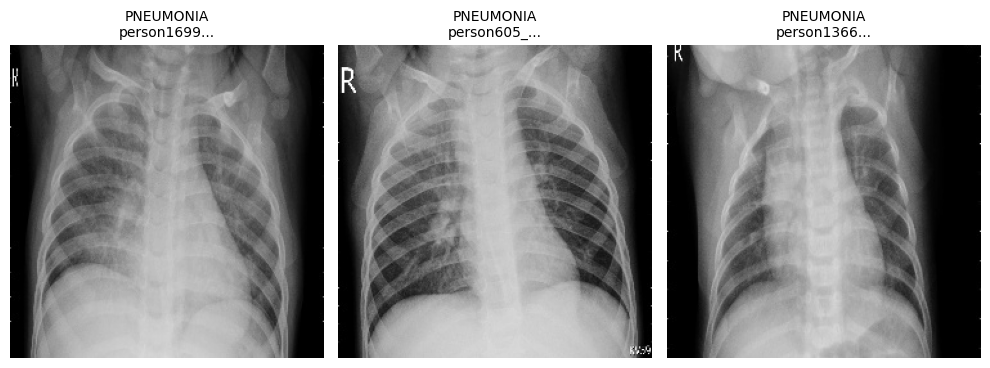

In [ ]:
def display_images(directory, class_label, num_images=3):
    """Displays a specified number of random images from the given directory with class label."""
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    random_images = random.sample(image_files, min(num_images, len(image_files)))

    plt.figure(figsize=(10, 5))
    for i, image_file in enumerate(random_images):
        img_path = os.path.join(directory, image_file)
        img = plt.imread(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{class_label}\n{image_file[:10]}...", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display 5 random images from each dataset with custom sizes
print("Validation Set Images:")
display_images(os.path.join(val_dir, 'NORMAL'), "NORMAL")
display_images(os.path.join(val_dir, 'PNEUMONIA'), "PNEUMONIA")

print("\nTraining Set Images:")
display_images(os.path.join(train_dir, 'NORMAL'), "NORMAL")
display_images(os.path.join(train_dir, 'PNEUMONIA'), "PNEUMONIA")

print("\nTesting Set Images:")
display_images(os.path.join(test_dir, 'NORMAL'), "NORMAL")
display_images(os.path.join(test_dir, 'PNEUMONIA'), "PNEUMONIA")

## Preprocessing

In [ ]:
Image_Size = (244, 244)

def preprocess_image(image_path, new_size=Image_Size):
    # Membaca gambar
    img = cv2.imread(image_path)

    # Mengubah ukuran gambar
    img_resized = cv2.resize(img, new_size)

    # Mengubah gambar ke grayscale
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

    return img_gray


# Loop melalui semua gambar dalam dataframe
def process_images_in_dataframe(df):
    for index, row in df.iterrows():
        image_path = row['Path']
        class_name = row['Class']
        image_name = row['Images']

        processed_img = preprocess_image(image_path)

        # Menyimpan gambar yang telah diproses ke lokasi asli
        cv2.imwrite(image_path, processed_img)
        print(f"Gambar {image_name} diproses dan disimpan di {image_path}")


# Proses gambar dengan path asli
process_images_in_dataframe(df_train)
process_images_in_dataframe(df_test)
process_images_in_dataframe(df_val)

Gambar IM-0236-0001.jpeg diproses dan disimpan di /content/dataset/chest_xray/train/NORMAL/IM-0236-0001.jpeg
Gambar IM-0633-0001.jpeg diproses dan disimpan di /content/dataset/chest_xray/train/NORMAL/IM-0633-0001.jpeg
Gambar IM-0750-0001.jpeg diproses dan disimpan di /content/dataset/chest_xray/train/NORMAL/IM-0750-0001.jpeg
Gambar IM-0485-0001.jpeg diproses dan disimpan di /content/dataset/chest_xray/train/NORMAL/IM-0485-0001.jpeg
Gambar NORMAL2-IM-1320-0001.jpeg diproses dan disimpan di /content/dataset/chest_xray/train/NORMAL/NORMAL2-IM-1320-0001.jpeg
Gambar IM-0405-0001.jpeg diproses dan disimpan di /content/dataset/chest_xray/train/NORMAL/IM-0405-0001.jpeg
Gambar IM-0715-0001.jpeg diproses dan disimpan di /content/dataset/chest_xray/train/NORMAL/IM-0715-0001.jpeg
Gambar IM-0757-0001.jpeg diproses dan disimpan di /content/dataset/chest_xray/train/NORMAL/IM-0757-0001.jpeg
Gambar NORMAL2-IM-1365-0001.jpeg diproses dan disimpan di /content/dataset/chest_xray/train/NORMAL/NORMAL2-IM-13

Validation Set Images:


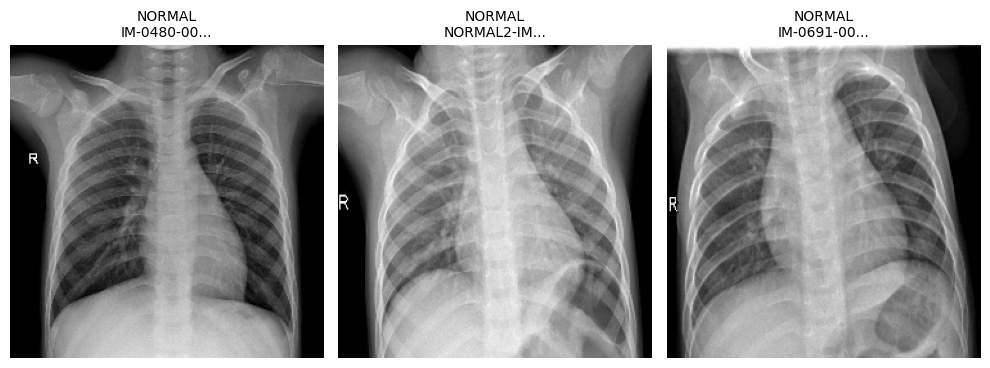

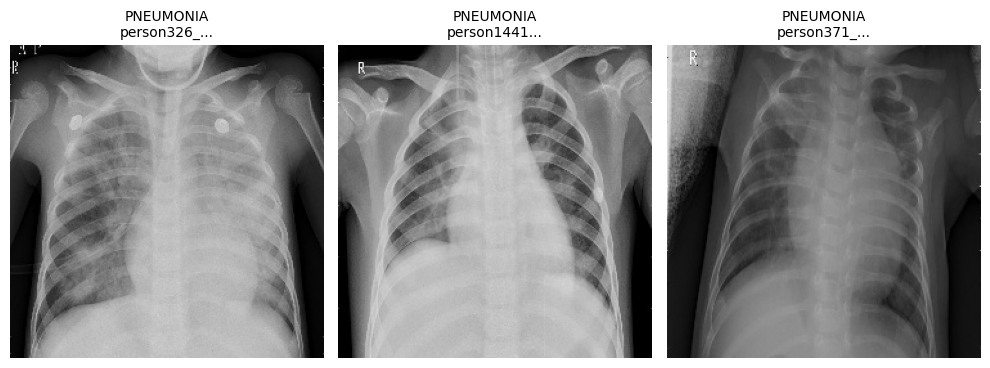


Training Set Images:


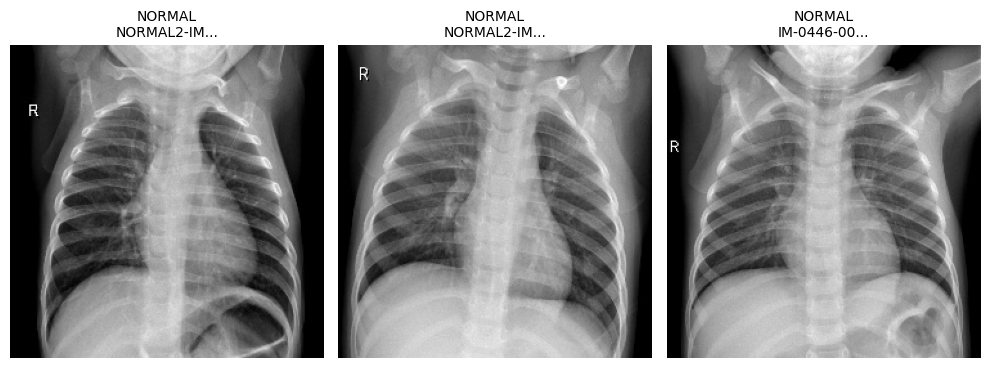

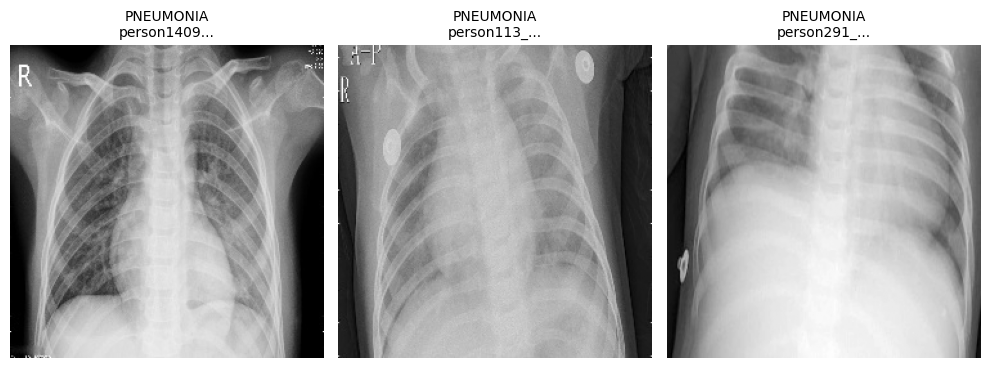


Testing Set Images:


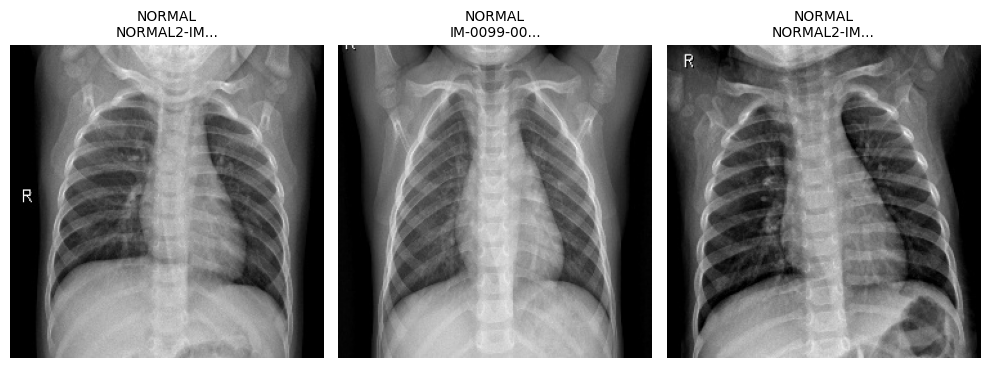

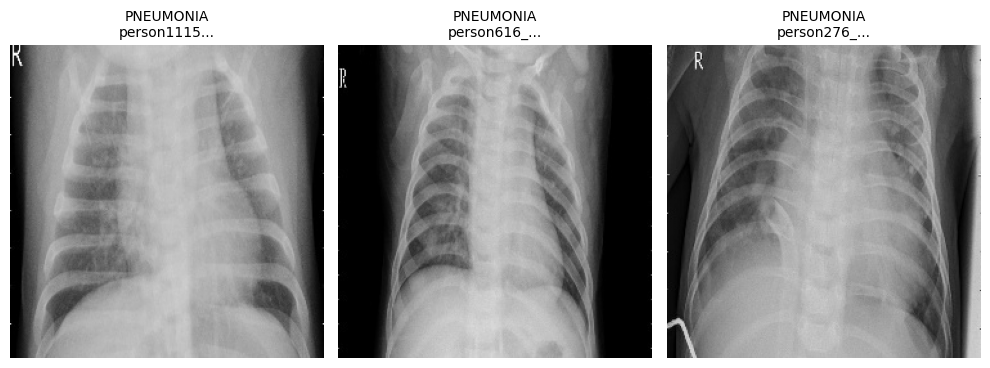

In [ ]:
# Menampilkan 5 gambar acak dari setiap dataset dengan ukuran kustom
print("Gambar dari Data Validasi:")
display_images(os.path.join(val_dir, 'NORMAL'), "NORMAL")
display_images(os.path.join(val_dir, 'PNEUMONIA'), "PNEUMONIA")

print("\nGambar dari Data Pelatihan:")
display_images(os.path.join(train_dir, 'NORMAL'), "NORMAL")
display_images(os.path.join(train_dir, 'PNEUMONIA'), "PNEUMONIA")

print("\nGambar dari Data Pengujian:")
display_images(os.path.join(test_dir, 'NORMAL'), "NORMAL")
display_images(os.path.join(test_dir, 'PNEUMONIA'), "PNEUMONIA")

## Feature Extraction

Ekstrak Fitur GRAY LEVEL CO-OCCURRENCE MATRIX(GLCM)

In [ ]:
import pandas as pd
import numpy as np
import cv2
from skimage.feature import graycomatrix, graycoprops

def extract_glcm_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Definisi sudut: 0, 45, 90, 135 derajat dalam radian
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    # Hitung GLCM untuk semua sudut
    glcm = graycomatrix(img, distances=[5], angles=angles, levels=256, symmetric=True, normed=True)

    features = {}
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'variance']

    for prop in properties:
        for i, angle in enumerate(angles):
            angle_name = f"{prop}_{int(np.degrees(angle))}"  # Contoh: contrast_0, contrast_45
            features[angle_name] = graycoprops(glcm, prop)[0, i]  # Ambil nilai untuk sudut tertentu

    return features

def extract_features_for_dataframe(df):
    features_list = []
    for index, row in df.iterrows():
        image_path = row['Path']
        glcm_features = extract_glcm_features(image_path)
        glcm_features['Class'] = row['Class']
        features_list.append(glcm_features)

    return pd.DataFrame(features_list)

glcm_train = extract_features_for_dataframe(df_train)
glcm_test = extract_features_for_dataframe(df_test)
glcm_val = extract_features_for_dataframe(df_val)

glcm_train.head()
glcm_test.head()
glcm_val.head()

contrast_0  contrast_45  contrast_90  contrast_135  dissimilarity_0  \
0  395.966150   412.685590   308.505093    398.280938        13.023458   
1  842.231875   738.388021   477.468259    837.116233        19.514953   
2  829.221157   833.660208   525.251183    832.635000        20.054788   
3  869.941937   785.724792   564.271949    855.378351        20.683895   
4  796.111170   740.329705   478.869315    710.588767        18.525808   

   dissimilarity_45  dissimilarity_90  dissimilarity_135  homogeneity_0  \
0         13.345347         10.352305          13.145382       0.130393   
1         18.796632         13.922063          19.853003       0.122314   
2         20.985347         16.218019          20.978125       0.068166   
3         20.110278         15.930156          20.765712       0.076213   
4         18.196927         13.960920          17.944010       0.147413   

   homogeneity_45  ...  energy_135  correlation_0  correlation_45  \
0        0.127858  ...    0.048792       0.936465        0.934319   
1        0.124420  ...    0.066955       0.898905        0.911177   
2        0.060328  ...    0.009003       0.853628        0.850902   
3        0.076975  ...    0.022447       0.867243        0.880580   
4        0.150214  ...    0.095109       0.889045        0.897013   

   correlation_90  correlation_135   variance_0  variance_45  variance_90  \
0        0.952885         0.936610  3116.117371  3141.571209  3273.934347   
1        0.944390         0.899323  4165.547286  4156.513635  4292.988334   
2        0.907303         0.851089  2832.586516  2795.677828  2833.175777   
3        0.918573         0.870086  3276.444776  3289.764789  3464.876273   
4        0.935336         0.901126  3587.547100  3594.282411  3702.758317   

   variance_135   Class  
0   3141.526962  NORMAL  
1   4157.440599  NORMAL  
2   2795.740737  NORMAL  
3   3292.107208  NORMAL  
4   3593.408878  NORMAL  

[5 rows x 25 columns]

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

X_train = glcm_train.drop(['Class'], axis=1)
y_train = glcm_train['Class']
X_val = glcm_val.drop(['Class'], axis=1)
y_val = glcm_val['Class']
X_test = glcm_test.drop(['Class'], axis=1)
y_test = glcm_test['Class']

# Encode label (NORMAL, PNEUMONIA jadi angka)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Normalisasi fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Create a mapping dictionary
class_mapping = {'NORMAL': 0, 'PNEUMONIA': 1}

# Map the 'Class' column using the mapping dictionary
glcm_train['Class'] = glcm_train['Class'].map(class_mapping)


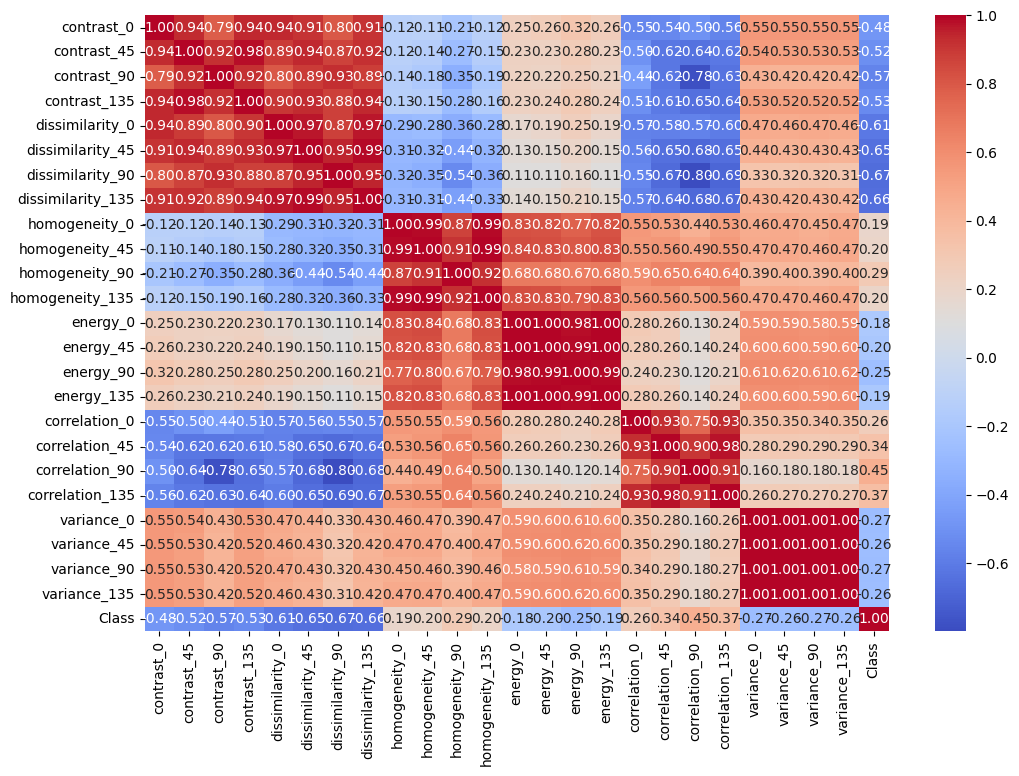

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung korelasi antar fitur
correlation_matrix = glcm_train.corr()

# Visualisasikan korelasi menggunakan heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

# Hitung korelasi absolut setiap fitur terhadap target
correlations = glcm_train.corr()['Class'].abs()

# Ambil 10 fitur dengan korelasi tertinggi
top_10_features = correlations.nlargest(11).index.tolist()  # 11 karena termasuk 'Class'

# Print 10 fitur dengan korelasi tertinggi
top_10_features

# Buang 'Class' dari daftar fitur
top_10_features.remove('Class')

# Seleksi hanya fitur dengan korelasi tertinggi
X_train = X_train[top_10_features]
X_val = X_val[top_10_features]
X_test = X_test[top_10_features]

# Normalisasi ulang fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
top_10_features


['dissimilarity_90',
 'dissimilarity_135',
 'dissimilarity_45',
 'dissimilarity_0',
 'contrast_90',
 'contrast_135',
 'contrast_45',
 'contrast_0',
 'correlation_90',
 'correlation_135']

In [ ]:
model = KNeighborsClassifier(n_neighbors=9)
model.fit(X_train_scaled, y_train_encoded)

# Evaluasi di validation set
y_val_pred = model.predict(X_val_scaled)
print("Confusion Matrix (Validation Set):")
print(confusion_matrix(y_val_encoded, y_val_pred))
print("Classification Report (Validation Set):")
print(classification_report(y_val_encoded, y_val_pred, target_names=label_encoder.classes_))

# Evaluasi di test set
y_test_pred = model.predict(X_test_scaled)
print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test_encoded, y_test_pred))
print("Classification Report (Test Set):")
print(classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_))

Confusion Matrix (Validation Set):
[[154   4]
 [139 288]]
Classification Report (Validation Set):
              precision    recall  f1-score   support

      NORMAL       0.53      0.97      0.68       158
   PNEUMONIA       0.99      0.67      0.80       427

    accuracy                           0.76       585
   macro avg       0.76      0.82      0.74       585
weighted avg       0.86      0.76      0.77       585

Confusion Matrix (Test Set):
[[151   8]
 [113 315]]
Classification Report (Test Set):
              precision    recall  f1-score   support

      NORMAL       0.57      0.95      0.71       159
   PNEUMONIA       0.98      0.74      0.84       428

    accuracy                           0.79       587
   macro avg       0.77      0.84      0.78       587
weighted avg       0.87      0.79      0.81       587



In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

k_range = range(1, 41)
cv_scores = []

# Cross-validation pakai data latih
for k in k_range:
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model, X_train_scaled, y_train_encoded, cv=5, scoring='accuracy')  # 5-fold CV
    cv_scores.append(scores.mean())

# Menentukan k terbaik
optimal_k = k_range[np.argmax(cv_scores)]
print(f"Optimal k berdasarkan cross-validation: {optimal_k}")

Optimal k berdasarkan cross-validation: 5


In [ ]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_scaled, y_train_encoded)

# Evaluasi di validation set
y_val_pred = model.predict(X_val_scaled)
print("Confusion Matrix (Validation Set):")
print(confusion_matrix(y_val_encoded, y_val_pred))
print("Classification Report (Validation Set):")
print(classification_report(y_val_encoded, y_val_pred, target_names=label_encoder.classes_))

# Evaluasi di test set
y_test_pred = model.predict(X_test_scaled)
print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test_encoded, y_test_pred))
print("Classification Report (Test Set):")
print(classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_))

Confusion Matrix (Validation Set):
[[152   6]
 [137 290]]
Classification Report (Validation Set):
              precision    recall  f1-score   support

      NORMAL       0.53      0.96      0.68       158
   PNEUMONIA       0.98      0.68      0.80       427

    accuracy                           0.76       585
   macro avg       0.75      0.82      0.74       585
weighted avg       0.86      0.76      0.77       585

Confusion Matrix (Test Set):
[[152   7]
 [108 320]]
Classification Report (Test Set):
              precision    recall  f1-score   support

      NORMAL       0.58      0.96      0.73       159
   PNEUMONIA       0.98      0.75      0.85       428

    accuracy                           0.80       587
   macro avg       0.78      0.85      0.79       587
weighted avg       0.87      0.80      0.81       587



In [ ]:
import joblib

# Simpan model KNN yang telah dilatih ke dalam file 'model.pkl'
joblib.dump(model, 'model.pkl')

# (Opsional) Simpan objek pendukung lainnya:
# - 'scaler.pkl' untuk menyimpan objek normalisasi/standarisasi data
# - 'label.pkl' untuk menyimpan encoder label (jika label dalam bentuk teks)
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label.pkl')

['label.pkl']

In [ ]:
import pandas as pd
from google.colab import files  # Untuk upload file di Google Colab
import cv2
import joblib
import os
from skimage.feature import graycomatrix, graycoprops
import numpy as np

# Upload file gambar dari pengguna
uploaded = files.upload()

for fn in uploaded.keys():
  print(f'File "{fn}" berhasil diunggah dengan ukuran {len(uploaded[fn])} byte.')

  # Menyimpan path gambar yang diunggah
  uploaded_image_path = fn

  # Pra-pemrosesan gambar sebelum ekstraksi fitur (fungsi preprocess_image harus sudah didefinisikan sebelumnya)
  processed_uploaded_img = preprocess_image(uploaded_image_path)

  # Simpan gambar hasil pra-pemrosesan sementara (opsional, bisa juga langsung diproses tanpa menyimpan)
  temp_processed_path = 'temp_processed_image.png'
  cv2.imwrite(temp_processed_path, processed_uploaded_img)

  # Ekstrak fitur GLCM dari gambar hasil pra-pemrosesan
  glcm_features_uploaded = extract_glcm_features(temp_processed_path)

  # Konversi fitur menjadi DataFrame agar sesuai format input model
  df_uploaded_features = pd.DataFrame([glcm_features_uploaded])

  # --- PENYESUAIAN FITUR ---
  # Pilih hanya fitur yang digunakan saat pelatihan (misalnya: 10 fitur terbaik)
  try:
      df_uploaded_features = df_uploaded_features[top_10_features]
  except NameError:
      print("Kesalahan: daftar 'top_10_features' tidak ditemukan. Pastikan variabel tersebut telah didefinisikan sebelumnya.")
      # Kamu bisa memuat atau menghitung ulang 'top_10_features' di sini jika diperlukan.
      pass
  # --- END ---

  # Muat kembali objek scaler (digunakan saat pelatihan) dan lakukan normalisasi fitur
  loaded_scaler = joblib.load('scaler.pkl')
  uploaded_features_scaled = loaded_scaler.transform(df_uploaded_features)

  # Muat model KNN yang telah dilatih
  loaded_model = joblib.load('model.pkl')

  # Prediksi kelas gambar berdasarkan fitur yang telah dinormalisasi
  prediction_encoded = loaded_model.predict(uploaded_features_scaled)

  # Dekode hasil prediksi ke label aslinya
  loaded_label_encoder = joblib.load('label.pkl')
  prediction_label = loaded_label_encoder.inverse_transform(prediction_encoded)

  # Tampilkan hasil prediksi
  print(f"Kelas yang diprediksi untuk gambar yang diunggah adalah: {prediction_label[0]}")

  # Hapus file gambar hasil pra-pemrosesan sementara
  os.remove(temp_processed_path)


Saving person1950_bacteria_4881.jpeg to person1950_bacteria_4881 (3).jpeg
User uploaded file "person1950_bacteria_4881 (3).jpeg" with length 86599 bytes
The predicted class for the uploaded image is: PNEUMONIA


referensi https://openlibrarypublications.telkomuniversity.ac.id/index.php/engineering/article/view/14271/14055

https://e-jurnal.lppmunsera.org/index.php/jsii/article/view/9157/3239

https://github.com/alfianhid/Feature-Extraction-Gray-Level-Co-occurrence-Matrix-GLCM-with-Python/blob/master/Feature_Extraction_Gray_Level_Co_occurrence_Matrix_(GLCM)_with_Python.ipynb